In [2]:
import kagglehub

path = kagglehub.dataset_download("sampadab17/network-intrusion-detection")

print("Path to dataset files:", path)

100%|██████████| 818k/818k [00:01<00:00, 627kB/s]

Extracting files...
Path to dataset files: C:\Users\Firdose Anjum\.cache\kagglehub\datasets\sampadab17\network-intrusion-detection\versions\1


In [48]:
import numpy as np
import pandas as pd
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.neural_network import BernoulliRBM
from sklearn.svm import SVC

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (7, 5)

In [49]:
data = pd.read_csv("C:\\Users\\Firdose Anjum\\.cache\\kagglehub\\datasets\\sampadab17\\network-intrusion-detection\\versions\\1\\Train_data.csv")

In [50]:
data.columns

Index(['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
       'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
       'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
       'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
       'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate', 'class'],
      dtype='object')

In [51]:
data['class']

0         normal
1         normal
2        anomaly
3         normal
4         normal
          ...   
25187    anomaly
25188    anomaly
25189    anomaly
25190    anomaly
25191    anomaly
Name: class, Length: 25192, dtype: object

## Data preprocessing

In [52]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25192 entries, 0 to 25191
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     25192 non-null  int64  
 1   protocol_type                25192 non-null  object 
 2   service                      25192 non-null  object 
 3   flag                         25192 non-null  object 
 4   src_bytes                    25192 non-null  int64  
 5   dst_bytes                    25192 non-null  int64  
 6   land                         25192 non-null  int64  
 7   wrong_fragment               25192 non-null  int64  
 8   urgent                       25192 non-null  int64  
 9   hot                          25192 non-null  int64  
 10  num_failed_logins            25192 non-null  int64  
 11  logged_in                    25192 non-null  int64  
 12  num_compromised              25192 non-null  int64  
 13  root_shell      

In [53]:
data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [54]:
y = data['class']       
X = data.drop(columns=['class'])

In [55]:
X = pd.get_dummies(X)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [56]:
X_scaled.shape

(25192, 118)

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

##### Features from the hidden layer of the RBM will then be used to train a classifier which will perform the final task of classifying normal v/s attack signals

In [58]:
rbm = BernoulliRBM(random_state=42)
svm = SVC(kernel="rbf", random_state=42)

pipeline = Pipeline([
    ("rbm", rbm),
    ("svm", svm)
])

### Hyperparameter Tuning

In [59]:
param_grid = {
    'rbm__n_components': [32, 64, 128],
    'rbm__n_iter': [5, 10],     
    'svm__C': [1, 5, 10],
}

rand = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=5,         # tries only 5 combos
    cv=2,             # faster cross-validation
    n_jobs=-1,
    verbose=2,
    scoring='accuracy',
    random_state=42
)

print("Running RandomizedSearchCV")
rand.fit(X_train, y_train)

print("\nBest Validation Accuracy:", rand.best_score_)
print("Best Params:", rand.best_params_)

Running RandomizedSearchCV
Fitting 2 folds for each of 5 candidates, totalling 10 fits

Best Validation Accuracy: 0.9081887263241466
Best Params: {'svm__C': 10, 'rbm__n_iter': 5, 'rbm__n_components': 64}


### Training RBM+SVM

In [60]:
best_params = rand.best_params_

rbm_final = BernoulliRBM(
    n_components=best_params['rbm__n_components'],
    n_iter=20,                     
    learning_rate=0.01,
    random_state=42
)

rbm_final.fit(X_train)

X_train_rbm = rbm_final.transform(X_train)
X_test_rbm  = rbm_final.transform(X_test)

In [61]:
svm_final = SVC(
    kernel="rbf",
    C=best_params['svm__C'],
    gamma='scale',
    random_state=42
)

svm_final.fit(X_train_rbm, y_train)
y_pred = svm_final.predict(X_test_rbm)

In [62]:
print("\nFinal Test Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))


Final Test Accuracy: 0.8819793596189468

Classification Report:
               precision    recall  f1-score   support

     anomaly       0.94      0.80      0.86      3523
      normal       0.84      0.96      0.90      4035

    accuracy                           0.88      7558
   macro avg       0.89      0.88      0.88      7558
weighted avg       0.89      0.88      0.88      7558


Confusion Matrix:
 [[2806  717]
 [ 175 3860]]


### Accuracy v/s Hidden Units

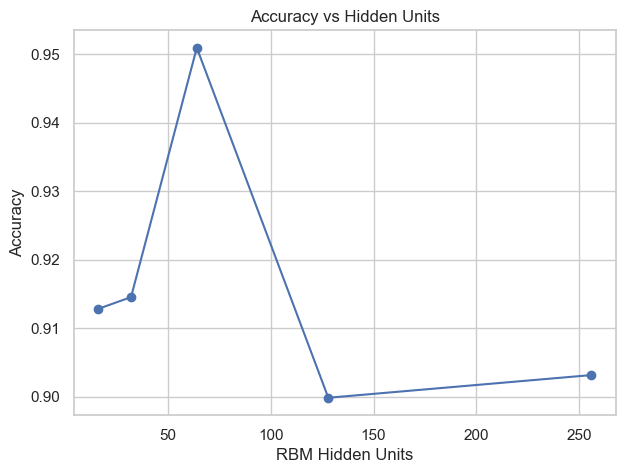

In [64]:
hidden_units = [16, 32, 64, 128, 256]
scores = []

for h in hidden_units:
    rbm_temp = BernoulliRBM(n_components=h, n_iter=10, random_state=42)
    rbm_temp.fit(X_train)
    X_train_rbm_temp = rbm_temp.transform(X_train)
    X_test_rbm_temp  = rbm_temp.transform(X_test)

    svm_temp = SVC(kernel='rbf', C=1.0, gamma='scale')
    svm_temp.fit(X_train_rbm_temp, y_train)
    scores.append(svm_temp.score(X_test_rbm_temp, y_test))

plt.plot(hidden_units, scores, marker='o')
plt.title("Accuracy vs Hidden Units")
plt.xlabel("RBM Hidden Units")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()